Import libraries

In [21]:
import os 
import math
import pickle
import random
import numpy as np
from tqdm import tqdm
from pprint import pprint 
from molmass import Formula
import rdkit.Chem as Chem
from msbuddy.utils import read_formula_str

import pandas as pd
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from matchms.importing import load_from_msp

In [2]:
data_path = "/data/rbg/users/klingmin/projects/MS_processing/data/final/MS_merged_w_mol_annotations.msp"
data = [s for s in tqdm(load_from_msp(data_path))]
plots_folder = "./plots"
if not os.path.exists(plots_folder): os.makedirs(plots_folder)

223757it [04:56, 753.84it/s] 


In [109]:
all_adducts = list(set([r.metadata["adduct"] for r in data]))
all_adducts

['[M+NH4]+',
 '[M+Na]+',
 '[M+HCOO]-',
 '[M+Cl]-',
 '[M-H]-',
 '[M]-',
 '[M]+',
 '[M+H]+']

Helper Functions

In [110]:
def get_energy_bins(energy):

    if energy <= 30.0:
        return 30.0
    if energy > 30.0 and energy <= 60.0:
        return 60.0
    if energy > 60.0 and energy <= 90.0:
        return 90.0
    if energy > 90.0 and energy <= 120.0:
        return 120.0
    
    return 150

In [112]:
def calculate_mass(formula):

    formula_dict = read_formula_str(formula)
    total_mass = 0 

    for k, v in formula_dict.items(): 

        if k in ["Cl", "Br"]:

            if k == "Cl":
                total_mass += 35.0 * v
            
            elif k == "Br":
                total_mass += 79.0 * v

            else:
                raise Exception() 
        
        else: 
            total_mass += Formula(k).mass * v 

    return total_mass

Group the data by the original dataset

In [116]:
data_by_dataset = {} 

for spec in data:

    metadata = spec.metadata
    adduct = metadata["adduct"]

    # Add on the theoretical mass and other details 
    formula_mass = calculate_mass(metadata["formula"])
    if adduct == "[M+NH4]+": theoretical_mass = formula_mass + 18.03806
    elif adduct == "[M+Na]+": theoretical_mass = formula_mass + 22.989769
    elif adduct == "[M+HCOO]-": theoretical_mass = formula_mass + 45.01684
    elif adduct == "[M+Cl]-": theoretical_mass = formula_mass + 35.0
    elif adduct == "[M-H]-": theoretical_mass = formula_mass - 1.00784
    elif adduct == "[M]-": theoretical_mass = formula_mass
    elif adduct == "[M]+": theoretical_mass = formula_mass
    elif adduct == "[M+H]+": theoretical_mass = formula_mass + 1.00784
    else: 
        print(adduct)
        raise Exception()

    spec.set("theoretical_mass", theoretical_mass)
    
    dataset = metadata["dataset"]
    if dataset not in data_by_dataset: data_by_dataset[dataset] = [] 
    data_by_dataset[dataset].append(spec)

Look at how much deviation in mass are there in the released datasets

In [117]:
mass_diff_by_dataset = {} 

for dataset, spec_list in data_by_dataset.items():
    
    for spec in tqdm(spec_list):

        metadata = spec.metadata
        adduct = metadata["adduct"]
        formula = metadata["formula"]
        theoretical_mass = metadata["theoretical_mass"]
        measured_mass = float(metadata["precursor_mz"])

        mass_diff = theoretical_mass - measured_mass

        if dataset not in mass_diff_by_dataset: mass_diff_by_dataset[dataset] = {}
        if "mass_diff" not in mass_diff_by_dataset[dataset]: mass_diff_by_dataset[dataset]["mass_diff"] = []
        if "mass" not in mass_diff_by_dataset[dataset]: mass_diff_by_dataset[dataset]["mass"] = []

        mass_diff_by_dataset[dataset]["mass_diff"].append(mass_diff)
        mass_diff_by_dataset[dataset]["mass"].append(measured_mass)

100%|██████████| 47324/47324 [00:05<00:00, 8296.71it/s]


Fit best fit lines to see the correlation of error with mass

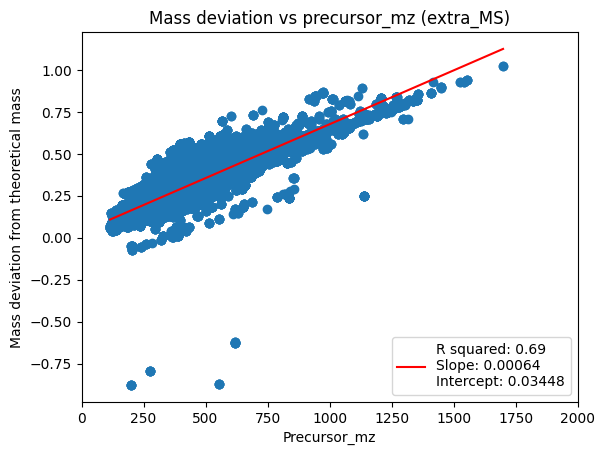

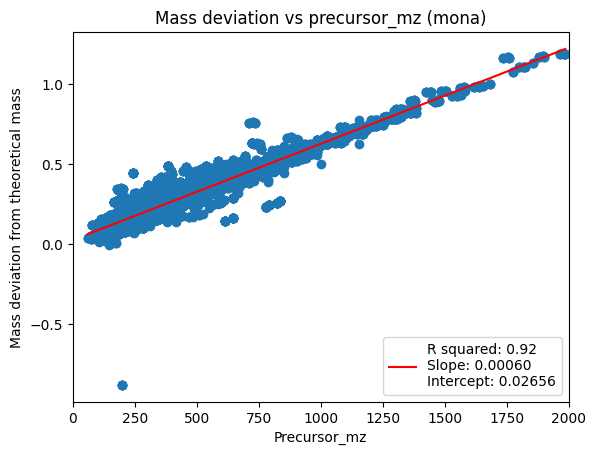

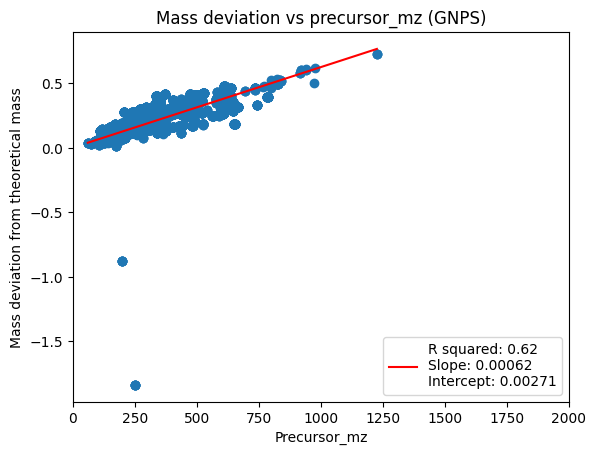

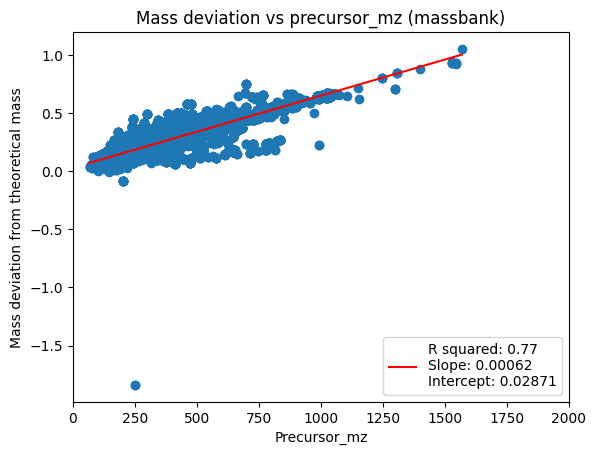

In [128]:
best_fit_params_dataset = {} 

for dataset, rec in mass_diff_by_dataset.items(): 

     # Fit a line to the rec
     slope, intercept = np.polyfit(rec["mass"], rec["mass_diff"], 1)
     best_fit_line = slope * np.array(sorted(rec["mass"])) + intercept
     correlation_value = pearsonr(rec["mass"], rec["mass_diff"])
     r_squared = correlation_value[0] ** 2

     best_fit_params_dataset[dataset] = {"slope": slope, "intercept": intercept}

     # Plot scatter plot
     plt.scatter(rec["mass"], rec["mass_diff"])
     plt.plot(sorted(rec["mass"]), best_fit_line, color='red', 
          label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

     # Add labels and title
     plt.title(f"Mass deviation vs precursor_mz ({dataset})")
     plt.xlabel('Precursor_mz')
     plt.ylabel('Mass deviation from theoretical mass')
     plt.xlim(0, 2000)

     # Show legend
     plt.legend(loc='lower right')
     plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_{dataset}.png"))
     plt.show()

Get the best fit line for the combined data 

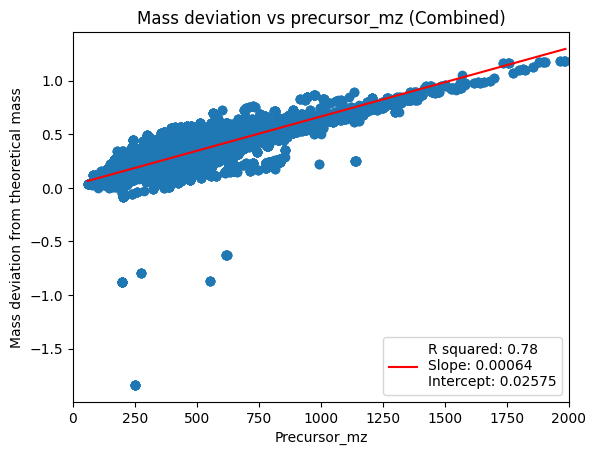

In [127]:
all_mass = [v for _, r in mass_diff_by_dataset.items() for v in r["mass"]]
all_diff = [v for _, r in mass_diff_by_dataset.items() for v in r["mass_diff"]]

# Fit a line to the rec
slope, intercept = np.polyfit(all_mass, all_diff, 1)
best_fit_line = slope * np.array(sorted(all_mass)) + intercept
correlation_value = pearsonr(all_mass, all_diff)
r_squared = correlation_value[0] ** 2
best_fit_params_dataset["all"] = {"slope": slope, "intercept": intercept}

# Plot scatter plot
plt.scatter(all_mass, all_diff)
plt.plot(sorted(all_mass), best_fit_line, color='red', 
        label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

# Add labels and title
plt.title(f"Mass deviation vs precursor_mz (Combined)")
plt.xlabel('Precursor_mz')
plt.ylabel('Mass deviation from theoretical mass')
plt.xlim(0, 2000)

# Show legend
plt.legend(loc='lower right')
plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_combined.png"))
plt.show()

Get different best fit lines based on energy

In [120]:
mass_diff_by_energy = {} 

for spec in tqdm(data):

    metadata = spec.metadata
    adduct = metadata["adduct"]
    formula = metadata["formula"]
    theoretical_mass = metadata["theoretical_mass"]
    measured_mass = float(metadata["precursor_mz"])

    energy = float(metadata["collision_energy"])
    energy_bin  = get_energy_bins(energy)

    mass_diff = theoretical_mass - float(metadata["precursor_mz"])

    if energy_bin not in mass_diff_by_energy: mass_diff_by_energy[energy_bin] = {}
    if "mass_diff" not in mass_diff_by_energy[energy_bin]: mass_diff_by_energy[energy_bin]["mass_diff"] = []
    if "mass" not in mass_diff_by_energy[energy_bin]: mass_diff_by_energy[energy_bin]["mass"] = []

    mass_diff_by_energy[energy_bin]["mass_diff"].append(mass_diff)
    mass_diff_by_energy[energy_bin]["mass"].append(measured_mass)

100%|██████████| 223757/223757 [00:26<00:00, 8468.38it/s] 


Look at how much mass deviations are there for each collision energy

0.271 0.112


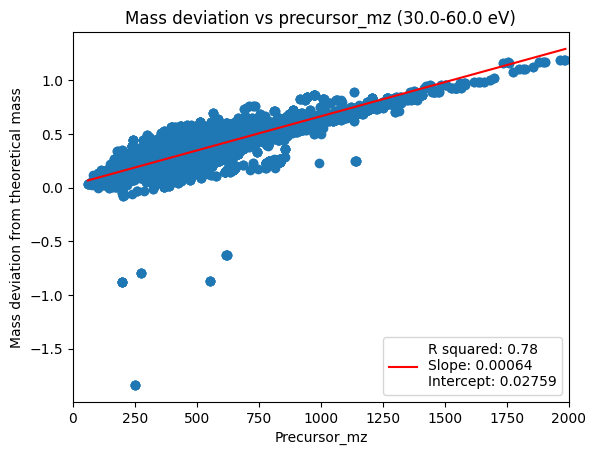

0.251 0.108


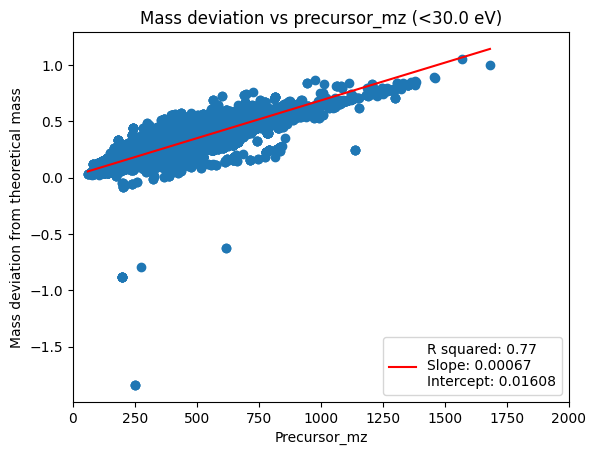

0.255 0.122


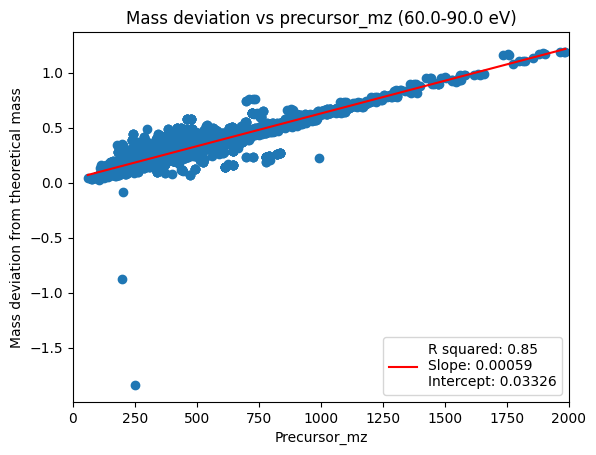

0.248 0.103


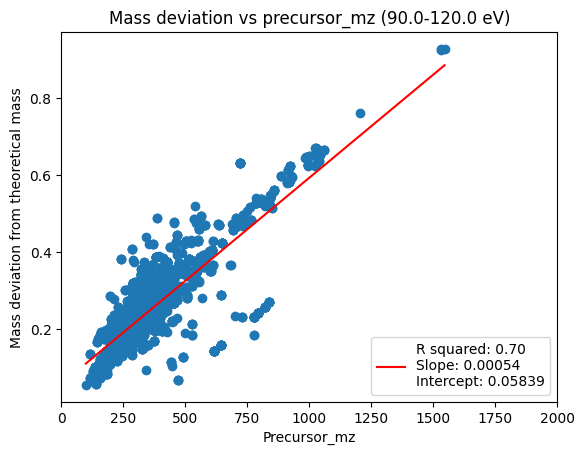

0.268 0.128


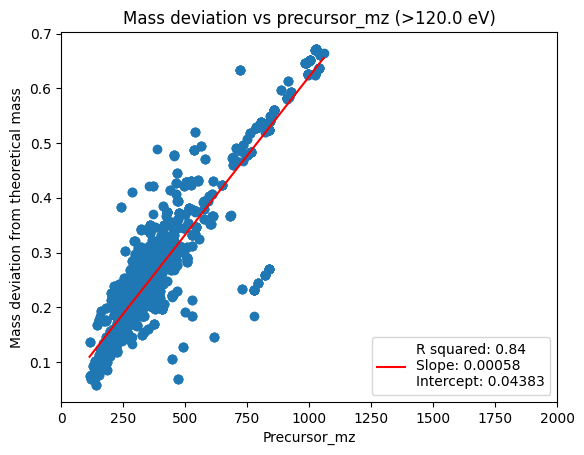

In [126]:
best_fit_params_energy = {} 

for energy, rec in mass_diff_by_energy.items(): 

   # Fit a line to the rec
   slope, intercept = np.polyfit(rec["mass"], rec["mass_diff"], 1)
   best_fit_line = slope * np.array(sorted(rec["mass"])) + intercept
   correlation_value = pearsonr(rec["mass"], rec["mass_diff"])
   r_squared = correlation_value[0] ** 2

   best_fit_params_energy[energy] = {"slope": slope, "intercept": intercept}

   # Plot scatter plot
   plt.scatter(rec["mass"], rec["mass_diff"])
   plt.plot(sorted(rec["mass"]), best_fit_line, color='red', 
      label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

   # Add labels and title
   if energy not in [30.0, 150.0]:
      text = f"{energy-30.0}-{energy} eV"
   elif energy == 30.0:
      text = f"<{energy} eV"
   elif energy == 150.0:
      text = f">{energy-30.0} eV"

   plt.title(f"Mass deviation vs precursor_mz ({text})")
   plt.xlabel('Precursor_mz')
   plt.ylabel('Mass deviation from theoretical mass')
   plt.xlim(0, 2000)

   # Show legend
   plt.legend(loc='lower right')
   plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_{energy}_ev.png"))
   mean_diff, std_diff = np.round(np.mean(rec["mass_diff"]), 3), np.round(np.std(rec["mass_diff"]), 3)
   print(mean_diff, std_diff)
   plt.show()

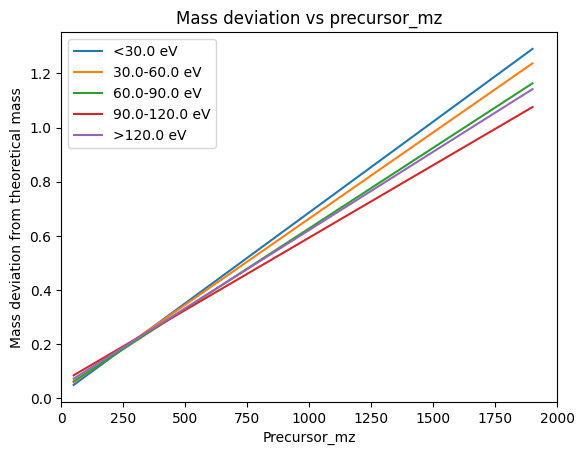

In [125]:
energy_levels = sorted(best_fit_params_energy.keys())

for energy in energy_levels:

   energy = float(energy)
   params = best_fit_params_energy[energy]
   masses = np.linspace(50, 1900, 500)
   best_fit_line = params["slope"] * masses + params["intercept"]

   # Add labels and title
   if energy not in [30.0, 150.0]:
      text = f"{energy-30.0}-{energy} eV"
   elif energy == 30.0:
      text = f"<{energy} eV"
   elif energy == 150.0:
      text = f">{energy-30.0} eV"
   
   plt.plot(masses, best_fit_line,  label = text)

plt.title(f"Mass deviation vs precursor_mz")
plt.xlabel('Precursor_mz')
plt.ylabel('Mass deviation from theoretical mass')
plt.xlim(0, 2000)
plt.legend()
plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_energy_combined_lines.png"))
plt.show()

Get mass diff by instrument

In [123]:
mass_diff_by_instrument = {} 

for spec in tqdm(data):

    metadata = spec.metadata
    adduct = metadata["adduct"]
    formula = metadata["formula"]
    instrument_type = metadata["instrument_type"]
    theoretical_mass = metadata["theoretical_mass"]
    measured_mass = float(metadata["precursor_mz"])

    mass_diff = theoretical_mass - float(metadata["precursor_mz"])

    if instrument_type not in mass_diff_by_instrument: mass_diff_by_instrument[instrument_type] = {}
    if "mass_diff" not in mass_diff_by_instrument[instrument_type]: mass_diff_by_instrument[instrument_type]["mass_diff"] = []
    if "mass" not in mass_diff_by_instrument[instrument_type]: mass_diff_by_instrument[instrument_type]["mass"] = []

    mass_diff_by_instrument[instrument_type]["mass_diff"].append(mass_diff)
    mass_diff_by_instrument[instrument_type]["mass"].append(measured_mass)

100%|██████████| 223757/223757 [00:27<00:00, 8173.23it/s]


ESI-ITFT 0.279 0.107
LC-ESI-QFT 0.224 0.098
LC-ESI-ITFT 0.23 0.104
LC-ESI-QTOF 0.224 0.098
ESI-QFT 0.297 0.15
ESI-QTOF 0.194 0.107
LC-ESI-IT 0.123 0.11
APCI-ITFT 0.197 0.047
LC-ESI-QQ 0.199 0.084
ISE-IT 0.272 0.135


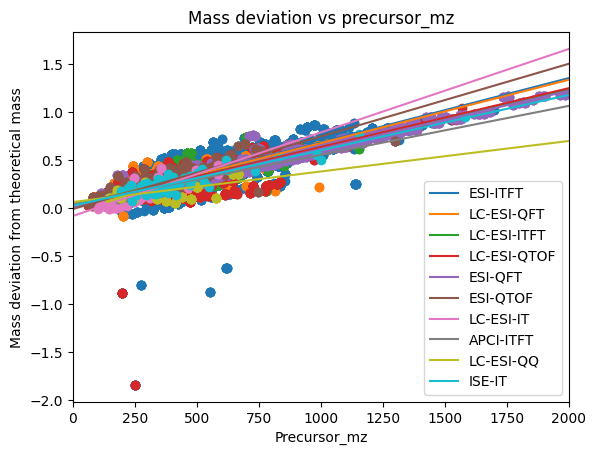

In [124]:
best_fit_params_instrument = {} 

for instrument, rec in mass_diff_by_instrument.items(): 
   
   # if instrument not in ["ESI-ITFT", "LC-ESI-ITFT", "ESI-QTOF", "ESI-QFT"]: continue

   # Fit a line to the rec
   slope, intercept = np.polyfit(rec["mass"], rec["mass_diff"], 1)
   best_fit_line = slope * np.linspace(0,2000,500) + intercept
   correlation_value = pearsonr(rec["mass"], rec["mass_diff"])
   r_squared = correlation_value[0] ** 2

   best_fit_params_instrument[instrument] = {"slope": slope, "intercept": intercept}

   # Plot scatter plot
   plt.scatter(rec["mass"], rec["mass_diff"])
   plt.plot(np.linspace(0,2000,500), best_fit_line, 
      label=f'{instrument}')

   plt.title(f"Mass deviation vs precursor_mz")
   plt.xlabel('Precursor_mz')
   plt.ylabel('Mass deviation from theoretical mass')
   plt.xlim(0, 2000)

   # Show legend
   plt.legend(loc='lower right')
   mean_diff, std_diff = np.round(np.mean(rec["mass_diff"]), 3), np.round(np.std(rec["mass_diff"]), 3)
   print(instrument, mean_diff, std_diff)
   plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_diff_insstrument.png"))
   # plt.show()

Get mass deviation by adduct

In [131]:
mass_diff_by_adduct = {} 

for spec in tqdm(data):

    metadata = spec.metadata
    adduct = metadata["adduct"]
    formula = metadata["formula"]
    instrument_type = metadata["instrument_type"]
    theoretical_mass = metadata["theoretical_mass"]
    measured_mass = float(metadata["precursor_mz"])

    mass_diff = theoretical_mass - float(metadata["precursor_mz"])

    if adduct not in mass_diff_by_adduct: mass_diff_by_adduct[adduct] = {}
    if "mass_diff" not in mass_diff_by_adduct[adduct]: mass_diff_by_adduct[adduct]["mass_diff"] = []
    if "mass" not in mass_diff_by_adduct[adduct]: mass_diff_by_adduct[adduct]["mass"] = []

    mass_diff_by_adduct[adduct]["mass_diff"].append(mass_diff)
    mass_diff_by_adduct[adduct]["mass"].append(measured_mass)

100%|██████████| 223757/223757 [00:28<00:00, 7954.21it/s] 


0.25 0.104


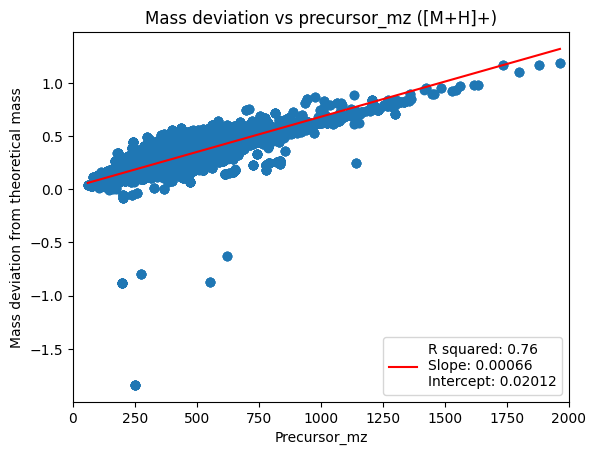

0.277 0.114


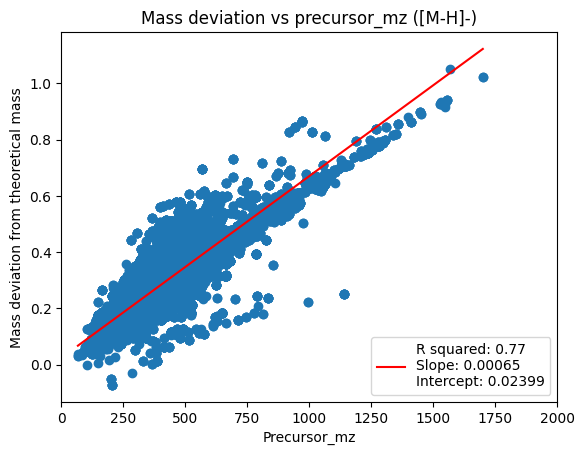

0.335 0.096


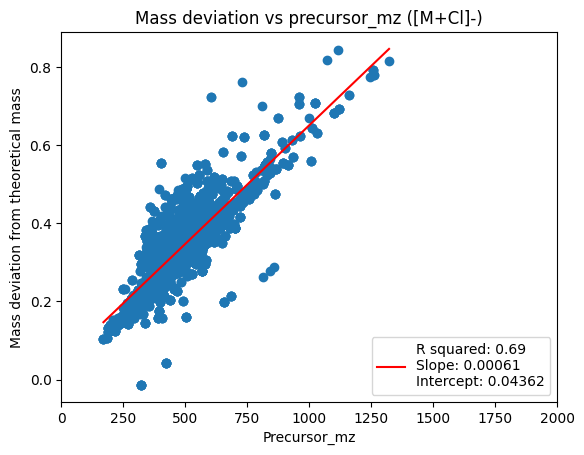

0.306 0.157


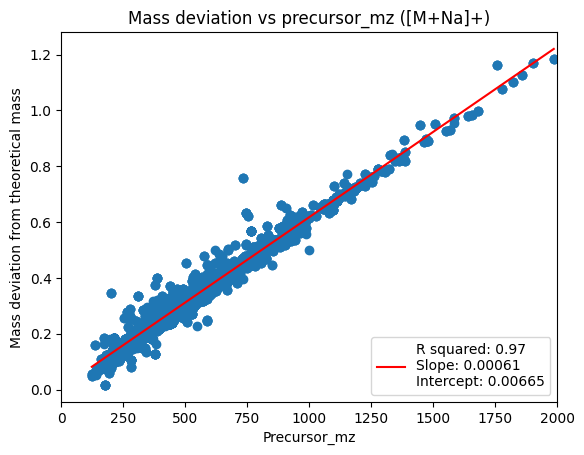

0.307 0.15


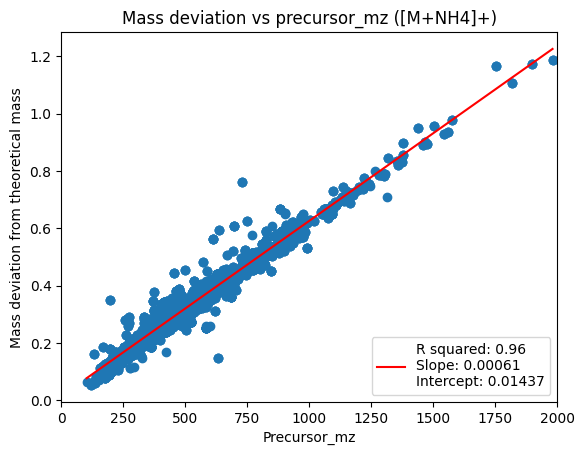

0.331 0.267


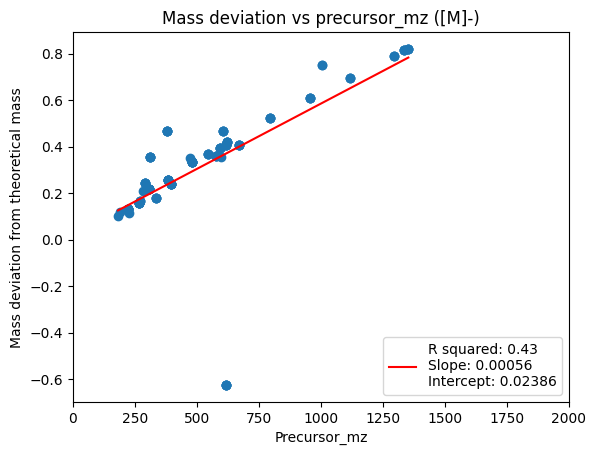

0.283 0.085


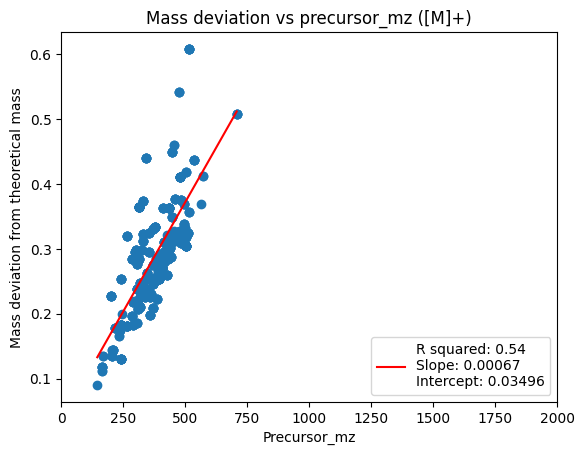

0.387 0.158


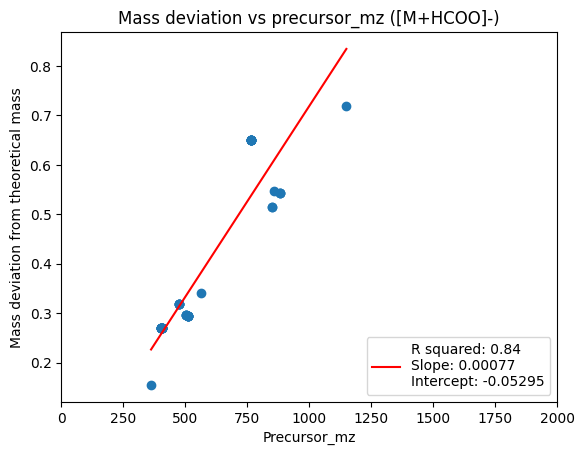

In [133]:
best_fit_params_adduct = {} 

for adduct, rec in mass_diff_by_adduct.items(): 

   # Fit a line to the rec
   slope, intercept = np.polyfit(rec["mass"], rec["mass_diff"], 1)
   best_fit_line = slope * np.array(sorted(rec["mass"])) + intercept
   correlation_value = pearsonr(rec["mass"], rec["mass_diff"])
   r_squared = correlation_value[0] ** 2

   best_fit_params_energy[energy] = {"slope": slope, "intercept": intercept}

   # Plot scatter plot
   plt.scatter(rec["mass"], rec["mass_diff"])
   plt.plot(sorted(rec["mass"]), best_fit_line, color='red', 
      label=f'R squared: {r_squared:.2f}\nSlope: {slope:.5f}\nIntercept: {intercept:.5f}')

   # Add labels and title
   plt.title(f"Mass deviation vs precursor_mz ({adduct})")
   plt.xlabel('Precursor_mz')
   plt.ylabel('Mass deviation from theoretical mass')
   plt.xlim(0, 2000)

   # Show legend
   plt.legend(loc='lower right')
   plt.savefig(os.path.join(plots_folder, f"correlation_of_mass_error_{adduct}.png"))
   mean_diff, std_diff = np.round(np.mean(rec["mass_diff"]), 3), np.round(np.std(rec["mass_diff"]), 3)
   print(mean_diff, std_diff)
   plt.show()

Get mass deviation by chemical formula

In [134]:
mass_diff_by_formula = {} 

for spec in tqdm(data):
    
    rec = spec.metadata
    adduct = rec["adduct"]

    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]
    theoretical_mass = rec["theoretical_mass"]
    mass_diff = theoretical_mass - measured_mass

    if formula not in mass_diff_by_formula: mass_diff_by_formula[formula] = {}
    if "mass_diff" not in mass_diff_by_formula[formula]: mass_diff_by_formula[formula]["mass_diff"] = []
    if "mass" not in mass_diff_by_formula[formula]: mass_diff_by_formula[formula]["mass"] = []
    if "measured_mass" not in mass_diff_by_formula[formula]: mass_diff_by_formula[formula]["measured_mass"] = []

    mass_diff_by_formula[formula]["mass_diff"].append(mass_diff)
    mass_diff_by_formula[formula]["mass"].append(theoretical_mass)
    mass_diff_by_formula[formula]["measured_mass"].append(measured_mass)

100%|██████████| 223757/223757 [00:27<00:00, 8099.29it/s]


In [135]:
mass_diff_by_formula_params = {} 

for formula, v in mass_diff_by_formula.items(): 

    # Fit a normal distribution to the data
    mu, std = stats.norm.fit(v["measured_mass"])
    mass_diff_by_formula_params[formula] = {"mean": mu, "std": std}

In [137]:
mass_diff_by_formula_params_sorted = sorted(mass_diff_by_formula_params.items(), key=lambda item: item[1]["std"], reverse = True)
mass_diff_by_formula_params_sorted[:10]

[('C22H46NO7P', {'mean': 480.8868666666667, 'std': 20.167476513759862}),
 ('C21H30O11', {'mean': 471.75449999999984, 'std': 19.873333955328192}),
 ('C21H34O6', {'mean': 399.21659999999997, 'std': 17.988340000000022}),
 ('C16H13ClO7', {'mean': 369.01604, 'std': 17.988340000000022}),
 ('C14H9Cl2F3N2O2', {'mean': 380.98037999999997, 'std': 17.988340000000022}),
 ('C19H17F2N3O3', {'mean': 390.10486000000003, 'std': 17.988340000000022}),
 ('C31H46N4O6', {'mean': 587.3228, 'std': 17.988339999999994}),
 ('C30H28O13', {'mean': 613.13405, 'std': 17.988339999999994}),
 ('C25H44N6O9', {'mean': 589.2980399999999, 'std': 17.988339999999994}),
 ('C36H62N4O13', {'mean': 775.4124, 'std': 17.988339999999994})]

Get mass deviation by structure

In [138]:
mass_diff_by_structure = {} 

for spec in tqdm(data):

    rec = spec.metadata
    adduct = rec["adduct"]
    measured_mass = float(rec["precursor_mz"])
    formula = rec["formula"]
    smiles = rec["smiles"]
    theoretical_mass = rec["theoretical_mass"]
    mass_diff = theoretical_mass - measured_mass

    if smiles not in mass_diff_by_structure: mass_diff_by_structure[smiles] = {}
    if "mass_diff" not in mass_diff_by_structure[smiles]: mass_diff_by_structure[smiles]["mass_diff"] = []
    if "mass" not in mass_diff_by_structure[smiles]: mass_diff_by_structure[smiles]["mass"] = []
    if "measured_mass" not in mass_diff_by_structure[smiles]: mass_diff_by_structure[smiles]["measured_mass"] = []

    mass_diff_by_structure[smiles]["mass_diff"].append(mass_diff)
    mass_diff_by_structure[smiles]["mass"].append(theoretical_mass)
    mass_diff_by_structure[smiles]["measured_mass"].append(measured_mass)

100%|██████████| 223757/223757 [00:27<00:00, 8144.58it/s]


In [139]:
mass_diff_by_structrure_params = {} 

for structure, v in mass_diff_by_structure.items(): 

    # Fit a normal distribution to the data
    mu, std = stats.norm.fit(v["measured_mass"])
    mass_diff_by_structrure_params[structure] = {"mean": mu, "std": std}

In [140]:
mass_diff_by_structrure_params_sorted = sorted(mass_diff_by_structrure_params.items(), key=lambda item: item[1]["std"], reverse = True)
mass_diff_by_structrure_params_sorted[:5]

[('CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O',
  {'mean': 738.0361000000001, 'std': 20.894383047029656}),
 ('CCCCCCCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N+](C)(C)C)O',
  {'mean': 482.9721333333332, 'std': 20.7375091336662}),
 ('CC1=C[C@@H]2[C@]([C@@H](C1=O)O)([C@]3(C[C@H]([C@H]([C@@]34CO4)O2)O[C@H]5[C@@H]([C@H]([C@@H]([C@H](O5)CO)O)O)O)C)CO',
  {'mean': 471.75449999999984, 'std': 19.873333955328192}),
 ('CCCCCC(=O)OC1C=C2COC(O)C2(O)C2(C)C(O)CCC(C)(C)C12',
  {'mean': 399.21659999999997, 'std': 17.988340000000022}),
 ('COC1=C(Cl)[C@](C)(O)c2c(oc(=O)c3c2cc(OC)cc3O)C1=O',
  {'mean': 369.01604, 'std': 17.988340000000022})]

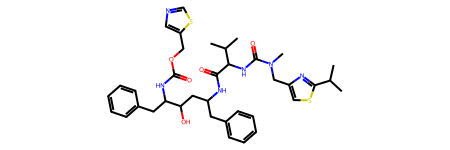

In [141]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[0][0])

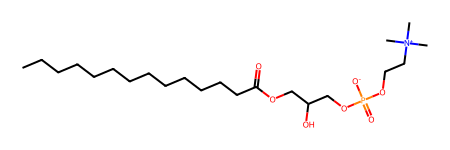

In [142]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[1][0])

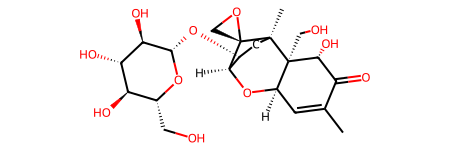

In [143]:
Chem.MolFromSmiles(mass_diff_by_structrure_params_sorted[2][0])

Understand the issue with having inaccurate mass

Build a linear model to predict the correct mass

In [144]:
# Get train test split
train_ratio = 0.8 
n_train = int(train_ratio * len(data))
random.shuffle(data)

train_data, test_data = data[:n_train], data[n_train:]

In [145]:
# Get the y 
train_error = np.array([r.metadata["theoretical_mass"] - float(r.metadata["precursor_mz"]) for r in train_data])
test_error = np.array([r.metadata["theoretical_mass"] - float(r.metadata["precursor_mz"]) for r in test_data])

In [198]:
def get_features(r):
    
    metadata = r.metadata

    # Get precursor_mz 
    mass = [float(r.metadata["precursor_mz"])]

    # Get the dataset 
    dataset = r.metadata["dataset"]
    datasets = [0,0,0,0]
    if dataset == "mona": datasets[0] = 1 
    if dataset == "massbank": datasets[1] = 1 
    if dataset == "GNPS": datasets[2] = 1 
    if dataset == "extra_MS": datasets[3] = 1 
    assert sum(datasets) == 1

    # Get energy 
    energy = float(metadata["collision_energy"])
    energy_bins = [0,0,0,0,0]
    energy_bin  = get_energy_bins(energy)
    if energy_bin == 30.0: energy_bins[0] = 1 
    if energy_bin == 60.0: energy_bins[1] = 1 
    if energy_bin == 90.0: energy_bins[2] = 1 
    if energy_bin == 120.0: energy_bins[3] = 1 
    if energy_bin == 150.0: energy_bins[4] = 1 
    assert sum(energy_bins) == 1

    # Get machine 
    machine = metadata["instrument_type"]
    machines = [0,0,0,0,0,0,0,0,0,0]
    if machine == "ESI-ITFT": machines[0] = 1 
    if machine == "LC-ESI-QFT": machines[1] = 1 
    if machine == "LC-ESI-ITFT": machines[2] = 1 
    if machine == "LC-ESI-QTOF": machines[3] = 1 
    if machine == "ESI-QFT": machines[4] = 1 
    if machine == "ESI-QTOF": machines[5] = 1 
    if machine == "LC-ESI-IT": machines[6] = 1 
    if machine == "APCI-ITFT": machines[7] = 1 
    if machine == "LC-ESI-QQ": machines[8] = 1 
    if machine == "ISE-IT": machines[9] = 1 
    assert sum(machines) == 1

    feats = mass # + energy_bins + machines + datasets

    return feats

In [199]:
# Get the features 
train_features = [] 

for r in train_data:
    
    feats = get_features(r)
    train_features.append(feats)

train_features = np.array(train_features)
print(train_features.shape)


(179005, 1)


In [201]:
print("Fitting the model")
model = LinearRegression()
model.fit(train_features, train_error)
print("Fitted the model")

print(model.coef_)
print(model.intercept_)

Fitting the model
Fitted the model
[0.00064006]
0.025712382062422046


In [164]:
formula_mass = {} 

for spec in tqdm(data):

    rec = spec.metadata
    formula = rec["formula"]
    formula_mass[formula] = calculate_mass(formula)

100%|██████████| 223757/223757 [01:04<00:00, 3489.50it/s]


In [178]:
correct, total, rank = 0, 0, [] 

for rec in tqdm(test_data):
    
    precursor_mz = float(rec.metadata["precursor_mz"])
    adduct = rec.metadata["adduct"]
    correct_formula = rec.metadata["formula"]

    if adduct == "[M+NH4]+": precursor_mz = precursor_mz - 18.03806
    elif adduct == "[M+Na]+": precursor_mz = precursor_mz - 22.989769
    elif adduct == "[M+HCOO]-": precursor_mz = precursor_mz - 45.01684
    elif adduct == "[M+Cl]-": precursor_mz = precursor_mz - 35.0
    elif adduct == "[M-H]-": precursor_mz = precursor_mz + 1.00784
    elif adduct == "[M]-": precursor_mz = precursor_mz
    elif adduct == "[M]+": precursor_mz = precursor_mz
    elif adduct == "[M+H]+": precursor_mz = precursor_mz - 1.00784

    current_diff = {k :abs(v-precursor_mz) for k, v in formula_mass.items()}
    all_diff_scores = list(sorted(set(current_diff.values())))
    correct_formula_diff = current_diff[correct_formula]

    index = all_diff_scores.index(correct_formula_diff)
    rank.append(index)

    if index == 0: correct += 1 
    total += 1 

acc = correct/total * 100 
print(acc)

100%|██████████| 44752/44752 [06:32<00:00, 114.00it/s]

4.158473364318914


In [203]:
correct_corrected, total, rank_corrected = 0, 0, []

for rec in tqdm(test_data):
    
    precursor_mz = float(rec.metadata["precursor_mz"])
    adduct = rec.metadata["adduct"]
    correct_formula = rec.metadata["formula"]
    feats = get_features(r)
    mass_error = model.predict(np.array(feats).reshape(1, -1))[0]

    if adduct == "[M+NH4]+": precursor_mz = precursor_mz - 18.03806
    elif adduct == "[M+Na]+": precursor_mz = precursor_mz - 22.989769
    elif adduct == "[M+HCOO]-": precursor_mz = precursor_mz - 45.01684
    elif adduct == "[M+Cl]-": precursor_mz = precursor_mz - 35.0
    elif adduct == "[M-H]-": precursor_mz = precursor_mz + 1.00784
    elif adduct == "[M]-": precursor_mz = precursor_mz
    elif adduct == "[M]+": precursor_mz = precursor_mz
    elif adduct == "[M+H]+": precursor_mz = precursor_mz - 1.00784
    
    precursor_mz = precursor_mz + mass_error
    
    # Get the error 
    current_diff = {k :abs(v-precursor_mz) for k, v in formula_mass.items()}
    all_diff_scores = list(sorted(set(current_diff.values())))
    correct_formula_diff = current_diff[correct_formula]

    index = all_diff_scores.index(correct_formula_diff)
    rank_corrected.append(index)

    if index == 0: correct_corrected += 1 
    total += 1
    
acc = correct_corrected/total * 100 
print(acc)

100%|██████████| 44752/44752 [09:44<00:00, 76.62it/s] 

8.730336074365391


In [204]:
recall_at_k, recall_at_k_corrected = [],[] 
total = len(rank)

for k in range(0, 100, 5):

    recall_at_k.append(len([r for r in rank if r <= k])/ total * 100 )
    recall_at_k_corrected.append(len([r for r in rank_corrected if r <= k]) / total * 100)

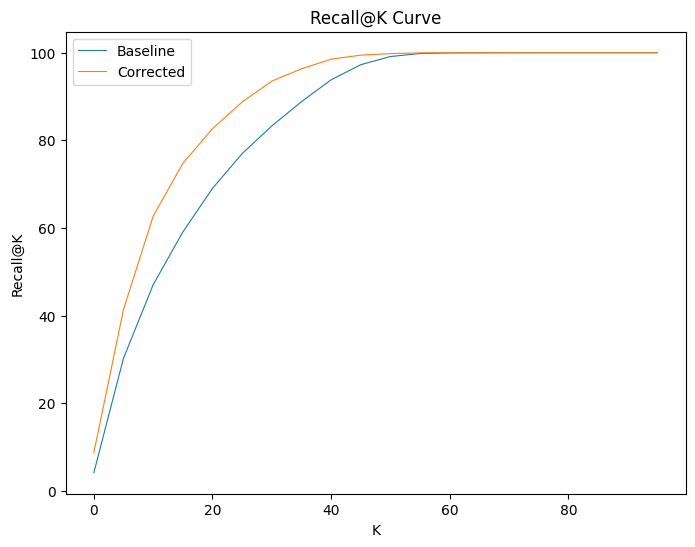

In [205]:
# Plot Recall@K curve with a thinner line
plt.figure(figsize=(8, 6))
plt.plot(range(0, 100, 5), recall_at_k, linewidth=0.8, label = "Baseline")
plt.plot(range(0, 100, 5), recall_at_k_corrected, linewidth=0.8, label = "Corrected")

# Add labels and title
plt.xlabel('K')
plt.ylabel('Recall@K')
plt.title('Recall@K Curve')
plt.legend()

# Show the plot
# plt.savefig(os.path.join(plots_folder, "correction_curve.png"))
plt.show()

In [40]:
recall_table = pd.DataFrame({"k" : range(0, 100, 5),
                             "recall_baseline": recall_at_k, 
                             "recall_corrected": recall_at_k_corrected})

recall_table

,k,recall_baseline,recall_corrected
0,0,6.839248,17.485434
1,5,34.778867,58.467956
2,10,52.039195,75.013242
3,15,64.141949,84.110169
4,20,73.298464,90.221133
5,25,80.647511,94.815943
6,30,86.957097,97.391419
7,35,92.545021,98.808263
8,40,96.861758,99.510064
9,45,99.079714,99.821239
